In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import re
from src.nielsen_helpers import get_s3_files, process_files, get_regex_domains, weights_dataframe
from src.helpers import  plot_top, set_size
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random  as rnd
import swifter
from datetime import timedelta
import numpy as np


In [3]:
# Latex Configuration
from matplotlib.patches import FancyArrowPatch
import matplotlib.font_manager as font_manager
import matplotlib.transforms as transforms
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib as mpl
import matplotlib.dates as dates
import scipy.stats 
import os

def handle_10(x):
    if "[10^{-3}]" not in x:
        return x
    x = x.replace("[10^{-3}]", "")
    
    pos = x.find("^")
    x = x + r'\times 10^{-3}'
    return x

params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': 'arial',
          'mathtext.fontset': 'cm',
          'mathtext.rm': 'serif',
    'text.usetex': False
    }

mpl.rcParams.update(params)

parlercolor = "#A50F11"
othercolor = "#377DB8"
allcolor = "#411B82"

# Loads data

In [4]:
start_date, end_date = "2020-05-01", "2021-07-01"

path = "/data/deplatforming/data/tmp_wall/df_fringe_to_weight_{}_to_{}.csv".format(start_date, end_date)
df_fringe = pd.read_csv(path)
df_fringe.activitydatetime = pd.to_datetime(df_fringe.activitydatetime)

path = "/data/deplatforming/data/tmp_wall/df_mainstream_to_weight_{}_to_{}.csv".format(start_date, end_date)
df_mainstream = pd.read_csv(path)
df_mainstream.activitydatetime = pd.to_datetime(df_mainstream.activitydatetime)

path = "/data/deplatforming/data/tmp_wall/df_all_to_weight_{}_to_{}.csv".format(start_date, end_date)
df_all = pd.read_csv(path)
df_all.activitydatetime = pd.to_datetime(df_all.activitydatetime)

In [5]:
start_date, end_date = "2020-05-01", "2021-07-01"

path = "/data/deplatforming/data/tmp_wall/df_fringe_to_weight_{}_to_{}_mob.csv".format(start_date, end_date)
df_fringe_mob = pd.read_csv(path)
df_fringe_mob.activitydatetime = pd.to_datetime(df_fringe_mob.activitydatetime)

path = "/data/deplatforming/data/tmp_wall/df_mainstream_to_weight_{}_to_{}_mob.csv".format(start_date, end_date)
df_mainstream_mob = pd.read_csv(path)
df_mainstream_mob.activitydatetime = pd.to_datetime(df_mainstream_mob.activitydatetime)

path = "/data/deplatforming/data/tmp_wall/df_all_to_weight_{}_to_{}_mob.csv".format(start_date, end_date)
df_all_mob = pd.read_csv(path)
df_all_mob.activitydatetime = pd.to_datetime(df_all_mob.activitydatetime)

# Weights data

In [6]:
ocols = ['age', 'gender', 'marital_status', 'edulevelid', 'educationdesc', 'incomeid',
         'incomedesc', 'emplstatusid', 'employmentstatusdesc', 'raceid',
         'racedesc', 'hispanicoriginid', 'hispanicorigindesc',
         'agegroup', 'spanish_language1']

# Fringe + Parler
w_mob, _, _, _ = weights_dataframe(
    pd.concat([df_fringe_mob, df_mainstream_mob]),
    weight_cols_to_keep=ocols)
w_mob["viewduration_w"] = w_mob["duration"] * w_mob["personweight"]
w_mob["viewduration"] = w_mob["duration"]

# All
w_all_mob, _, _, _ = weights_dataframe(df_all_mob, weight_cols_to_keep=ocols)
w_all_mob["viewduration_w"] = w_all_mob["duration"] * w_all_mob["personweight"]
w_all_mob["viewduration"] = w_all_mob["duration"]

/data/anaconda3/lib/python3.9/site-packages/charset_normalizer/api.py:105: UserWarning: Trying to detect encoding from a tiny portion of (29) byte(s).
  warn('Trying to detect encoding from a tiny portion of ({}) byte(s).'.format(length))


In [7]:
ocol = ["age", "gender_id", "race_id", "education_id", "income_group_id", "hispanic_origin_id"]
pathv = "s3://epfl-collaboration-paspkaoe1nx9ptad1k8rjh5maact6use1a-s3alias/"


# Fringe + Parler
w, _, _, _ = weights_dataframe(pd.concat([df_fringe, df_mainstream]),
    weight_cols_to_keep=ocol,
    nol_id_col="nol_id",
    weightcol="combo_visitors_weight",
    is_mobile=False,
    pathv=pathv)
w["viewduration_w"] = w["viewduration"] * w["combo_visitors_weight"]


# All
w_all, _, _, _ = weights_dataframe(df_all,
    weight_cols_to_keep=ocol,
    nol_id_col="nol_id",
    weightcol="combo_visitors_weight",
    is_mobile=False,
    pathv=pathv)

w_all["viewduration_w"] = w_all["viewduration"] * w_all["combo_visitors_weight"]

In [8]:
def weighted_agg(df, is_mobile=False, th=60):

    try:
        users =  df.drop_duplicates("mobile_id").mobile_id.nunique() 
        usersw =  df.drop_duplicates("mobile_id").personweight.sum() 
        userst = df.groupby("mobile_id").viewduration.sum()
        userst = df.groupby("mobile_id").viewduration.sum()
        userst = userst[userst > th]
        userst = userst.index.values.astype(float)
    except:
        users =  df.drop_duplicates("nol_id").nol_id.nunique()
        usersw =  df.drop_duplicates("nol_id").combo_visitors_weight.sum() 
        userst = df.groupby("nol_id").viewduration.sum()
        userst = userst[userst > th]
        userst = userst.index.values.astype(float)
    return pd.Series({
        "sumv": df.viewduration_w.sum(),
        "dur": df.viewduration.sum(),
        "users": users,
        "usersw": usersw
    })
    
w["is_parler"] = w["platform"] == "parler"
w["other"] = w["platform"].isin(["locals", "minds", "8kun", "dlive", "gab", "4chan"])
display((w.groupby("platform").sum().viewduration_w / 100000).sort_values())

display((w_mob.groupby("platform").sum().viewduration_w / 100000).sort_values())

platform
locals       5.978286e+02
minds        5.773365e+03
8kun         6.789624e+03
telegram     3.002157e+04
dlive        4.254452e+04
gab          5.515400e+04
4chan        5.648172e+04
parler       7.056673e+04
bitchute     1.015902e+05
mewe         1.173751e+05
rumble       1.421191e+05
snapchat     4.051760e+05
tiktok       6.199343e+05
whatsapp     9.807249e+05
linkedin     1.164095e+06
nextdoor     1.487137e+06
instagram    1.561289e+06
pinterest    1.847750e+06
reddit       3.049208e+06
twitter      5.790802e+06
youtube      6.397616e+07
facebook     7.658723e+07
Name: viewduration_w, dtype: float64

platform
minds        3.379208e+03
8kun         5.202088e+03
dlive        4.495546e+04
gab          8.720126e+04
bitchute     1.814003e+05
rumble       3.904984e+05
linkedin     6.762447e+05
parler       1.120489e+06
mewe         1.261280e+06
telegram     6.542674e+06
nextdoor     8.228612e+06
pinterest    2.537562e+07
reddit       3.480688e+07
whatsapp     7.428313e+07
twitter      8.499681e+07
snapchat     1.209704e+08
tiktok       1.529220e+08
instagram    1.972401e+08
youtube      4.059822e+08
facebook     5.796830e+08
Name: viewduration_w, dtype: float64

## Aggregated dataset

In [10]:
acc = []

for w_, w_all_, k in [(w, w_all, "desk"), 
                    (w_mob[w_mob.personweight > 0], w_all_mob[w_all_mob.personweight > 0], "mob")]:

    for platform in set(w_["platform"]):
        w_[platform] = w_["platform"] == platform
        t_is_platform = w_[w_[platform]].groupby(pd.Grouper(key="activitydatetime", freq="D"))\
                          .apply(weighted_agg).reset_index()
        t_is_platform["kind"] = "is_{}".format(platform) 
        t_is_platform["device"] = k
        acc += [t_is_platform]

    w_["is_fringe"] = w_["platform"].isin(
        ["locals", "parler", "minds", "8kun", "dlive", "gab", 
         "4chan", "rumble", "bitchute", "mewe", "telegram"])
    
    w_["is_fringe_not_parler"] = w_["platform"].isin(
        ["locals", "minds", "8kun", "dlive", "gab", 
         "4chan", "rumble", "bitchute", "mewe", "telegram"])
    
    w_["is_mainstream"] = w_["platform"].isin(
        ["facebook", "youtube", "instagram", "tiktok", 
         "twitter", "reddit", "pinterest",
         "linkedin", "whatsapp", "nextdoor", "snapchat"])
    

    
    t_is_fringe = w_[w_.is_fringe].groupby(pd.Grouper(key="activitydatetime", freq="D"))\
                      .apply(weighted_agg).reset_index()
    t_is_fringe["kind"] = "is_fringe"
    t_is_fringe["device"] = k

    t_is_fringe_not_parler = w_[w_.is_fringe_not_parler].groupby(pd.Grouper(key="activitydatetime", freq="D"))\
                      .apply(weighted_agg).reset_index()
    t_is_fringe_not_parler["kind"] = "is_fringe_not_parler"
    t_is_fringe_not_parler["device"] = k

    t_is_mainstream = w_[w_.is_mainstream].groupby(pd.Grouper(key="activitydatetime", freq="D"))\
                      .apply(weighted_agg).reset_index()    
    t_is_mainstream["kind"] = "is_mainstream"
    t_is_mainstream["device"] = k

    
    t_all = w_all_.groupby([pd.Grouper(key="activitydatetime", freq="D")])\
                 .apply(weighted_agg).reset_index() 
    t_all["kind"] = "all"
    t_all["device"] = k
    acc += [ t_is_fringe, t_is_fringe_not_parler, t_is_mainstream, t_all]

df_final = pd.concat(acc)
df_final.columns = ["activitydatetime", "viewduration_w", "viewduration", "dau", "dau_w", "kind", "device"]
df_final.to_csv("./data/df_trends_final.csv", index=False)

In [11]:
def plot_helper1(w_desktop,
                 w_all_desktop,
                 w_mob,
                 w_all_mob,
                 denom_main, 
                 slindw_main,
                 ylabel_main,
                 pathfig,
                 annotate_coords = None,
                 fmt = '%.1f', 
                 kval="sumv",
                 sept_dau=True):
    
    fontsize_text = 16
    fontsize_large = 18
    myFmt = mdates.DateFormatter('%b')
    xticks = mtick.FormatStrFormatter(fmt)

    fig = plt.figure(constrained_layout=False, figsize=(14, 5.85))
    
    axs = fig.subplot_mosaic(np.array([['desk', 'desk', 'mob', 'mob']]), 
                              gridspec_kw={ 'hspace': 1.4})
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    import matplotlib.transforms as transforms
    from matplotlib.lines import Line2D

    # MAIN PLOT 
    for w, w_all, k in [(w_desktop, w_all_desktop, "desk"), (w_mob, w_all_mob, "mob")]:
        
        w["parler"] = w["platform"] == "parler"
        w["is_fringe"] = w["platform"].isin(
            ["locals", "parler", "minds", "8kun", "dlive", "gab", 
             "4chan", "rumble", "bitchute", "mewe", "telegram"])
        t = w[w.is_fringe].groupby([pd.Grouper(key="activitydatetime", freq="D"), "parler"])\
                          .apply(weighted_agg).reset_index()
        t_all = w_all.groupby([pd.Grouper(key="activitydatetime", freq="D")])\
                     .apply(weighted_agg)
        t2 = t.set_index("activitydatetime")
        t3 = t2[t2.parler][kval].rolling(slindw_main, center=False).mean() / denom_main(t_all)
        axs[k].plot(t3, 
            label="Parler", #if k == "desk" else None, 
            color=parlercolor, ls=":", lw=2.25)
        t4 = t2[~t2.parler][kval].rolling(slindw_main, center=False).mean() / denom_main(t_all)
        axs[k].plot(t4, 
            label="Other fringe social media", #if k == "desk" else None, 
            color=othercolor, ls="--", lw=2)
        
        t5 = w[w.is_fringe].groupby([pd.Grouper(key="activitydatetime", freq="D")])\
                  .apply(weighted_agg)
        t5 = (t5[kval].rolling(slindw_main, center=False).mean() / denom_main(t_all))
        axs[k].plot(t5, 
            label="All fringe social media (incl. Parler)", #if k == "desk" else None, 
            color=allcolor, ls="-", lw=1.5)
        
#         return t2, t_all

    # AESTHETICS MAIN PLOT
    for k in ["desk", "mob"]:
        if k in ["desk"]:
            axs[k].set_ylabel(ylabel_main, size=fontsize_text)
        axs[k].yaxis.grid("#C0C0C0", ls=":")
        sns.despine(ax=axs[k])

        axs[k].axvline(pd.to_datetime("2020-11-03"), color="black", ls="--", zorder=-1, lw=1.25)
        axs[k].axvline(pd.to_datetime("2021-01-06"), color="black", ls="--", zorder=-1, lw=1.25)
        plot_top(axs[k], pd.to_datetime("2021-01-06"), text="Capitol attack", size=fontsize_text, delta=-0.01)

        axs[k].xaxis.set_major_locator(dates.MonthLocator(interval=1))
        axs[k].axvspan(pd.to_datetime("2021-01-11"), pd.to_datetime("2021-02-15"), color="#DDDDDD", zorder=-2,
                      label="Parler shutdown")
        axs[k].xaxis.set_major_formatter(myFmt)
        plot_top(axs[k], pd.to_datetime("2020-09-17"), text="2020", size=fontsize_text, delta=-1.21)
        plot_top(axs[k], pd.to_datetime("2021-03-17"), text="2021", size=fontsize_text, delta=-1.21)

        axs[k].yaxis.set_major_formatter(xticks)
        
        plot_top(axs[k], pd.to_datetime("2020-11-03"), text="Election", size=fontsize_text, delta=-0.01)
        if k == "desk":
            # ANNOTATE MAIN PLOT    
            if annotate_coords is not None:
                axs[k].annotate("Parler shutdown", xy=(pd.to_datetime("2021-02-17"), annotate_coords[0]), 
                                 xytext=(pd.to_datetime("2021-04-15"), annotate_coords[1]),
                                 xycoords="data", annotation_clip=False, ha="center", color="#777777",
                                 arrowprops={"connectionstyle": "arc3,rad=.5", 
                                             "arrowstyle": "-|>", 
                                             "color": "#777777"}, size=fontsize_text)

    accv = ""
    
    axs["desk"].tick_params(axis='both', which='major', labelsize=fontsize_text)
    axs["mob"].tick_params(axis='both', which='major', labelsize=fontsize_text)
    axs["desk"].set_title("Desktop Panel" + accv, pad=35, fontsize=fontsize_large, fontweight='bold')
    axs["desk"].set_ylim([-0.05, 1.15])
    axs["mob"].set_ylim([-0.26, 5.98])
    axs["desk"].set_yticks([0., 0.25, 0.5, 0.75, 1])
    axs["mob"].set_yticks([0., 1.3, 2.6, 3.9, 5.2])
    axs["mob"].set_title("Mobile Panel" + accv, pad=35, fontsize=fontsize_large, fontweight='bold')
    axs["desk"].legend(frameon=True, ncol=4, loc='upper center', bbox_to_anchor=(1, 1.375), fontsize=fontsize_text)

    set_size(fig, (14, 5.85))
    fig.savefig(pathfig, bbox_inches="tight", dpi=300)
    fig.savefig(pathfig.replace("pdf", "png"), bbox_inches="tight",dpi=300)

/tmp/ipykernel_13999/3848133739.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w["parler"] = w["platform"] == "parler"
/tmp/ipykernel_13999/3848133739.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w["is_fringe"] = w["platform"].isin(


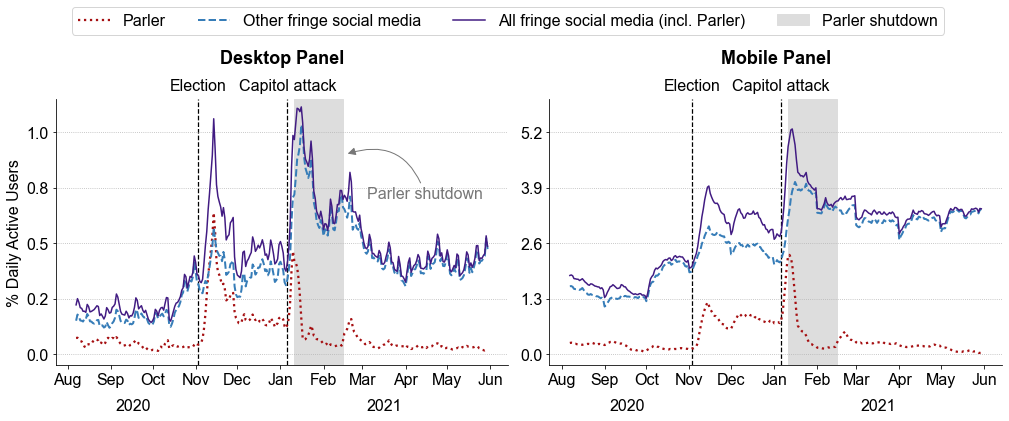

In [12]:
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
plot_helper1(
w_desktop = w,
w_mob = w_mob[w_mob.personweight > 0],
w_all_desktop = w_all,
w_all_mob = w_all_mob[w_all_mob.personweight > 0],
denom_main = lambda sumv: sumv.usersw/100, 
slindw_main = 7,
ylabel_main = '% Daily Active Users',
annotate_coords = (0.9, 0.7),
pathfig = "./images/overall_br.pdf",
fmt = '%.1f',
kval = "usersw",
sept_dau=False)

# CHECKS

facebook
youtube
instagram
tiktok
twitter
reddit
pinterest
linkedin
whatsapp
nextdoor
snapchat


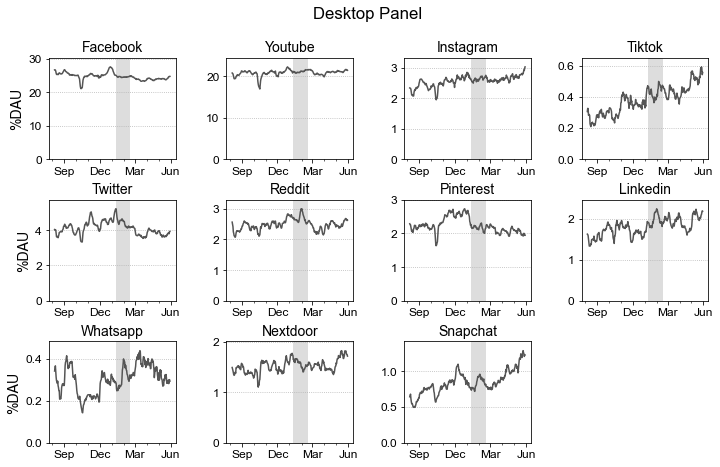

facebook
youtube
instagram
tiktok
twitter
reddit
pinterest
linkedin
whatsapp
nextdoor
snapchat


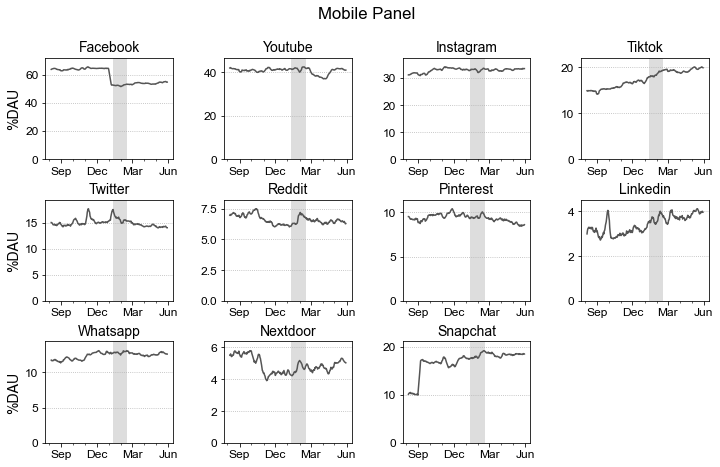

facebook
youtube
instagram
tiktok
twitter
reddit
pinterest
linkedin
whatsapp
nextdoor
snapchat


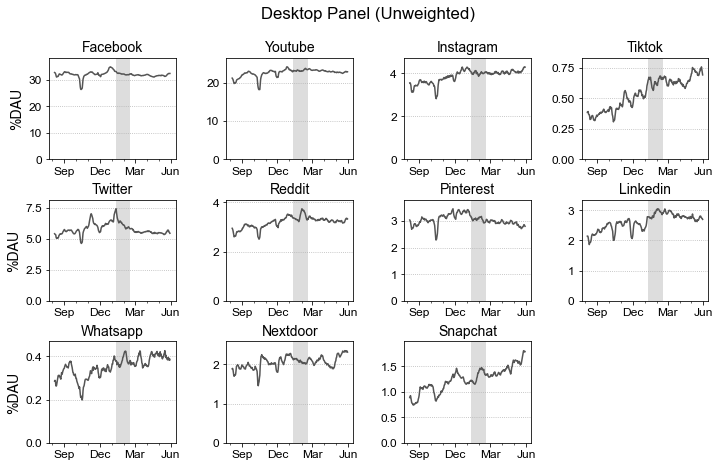

facebook
youtube
instagram
tiktok
twitter
reddit
pinterest
linkedin
whatsapp
nextdoor
snapchat


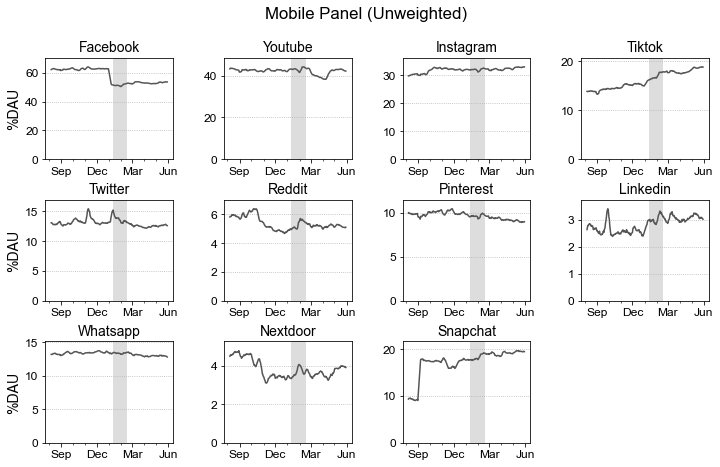

facebook
youtube
instagram
tiktok
twitter
reddit
pinterest
linkedin
whatsapp
nextdoor
snapchat


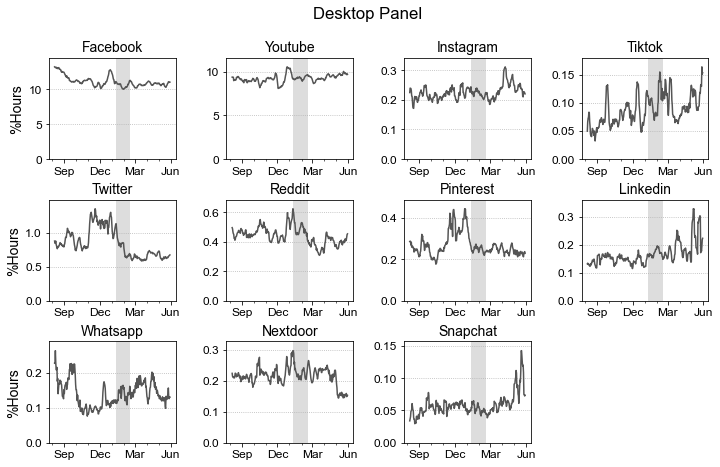

facebook
youtube
instagram
tiktok
twitter
reddit
pinterest
linkedin
whatsapp
nextdoor
snapchat


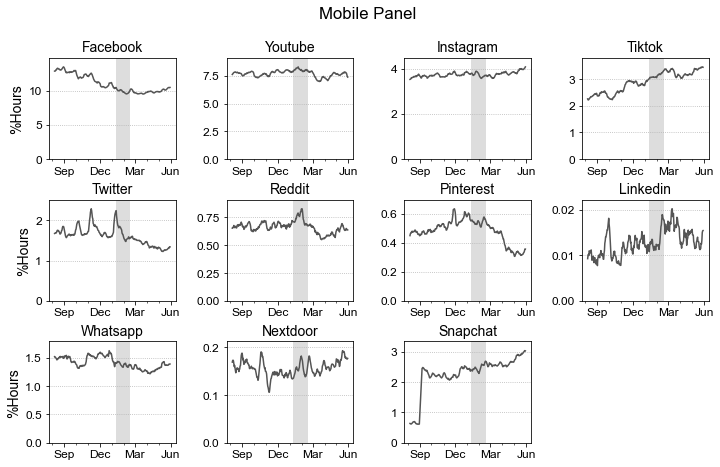

facebook
youtube
instagram
tiktok
twitter
reddit
pinterest
linkedin
whatsapp
nextdoor
snapchat


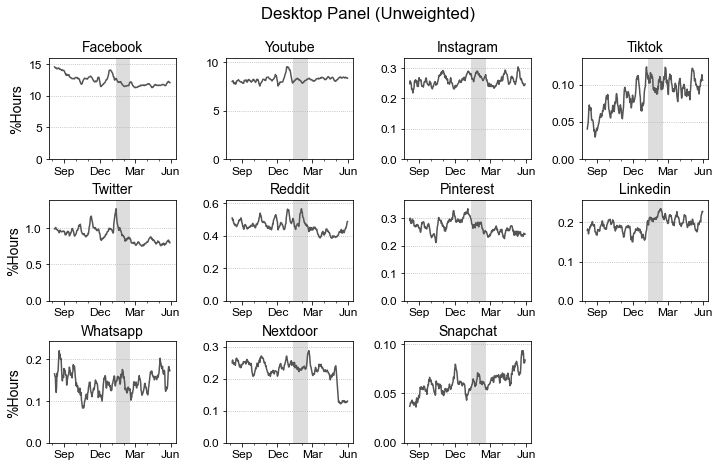

facebook
youtube
instagram
tiktok
twitter
reddit
pinterest
linkedin
whatsapp
nextdoor
snapchat


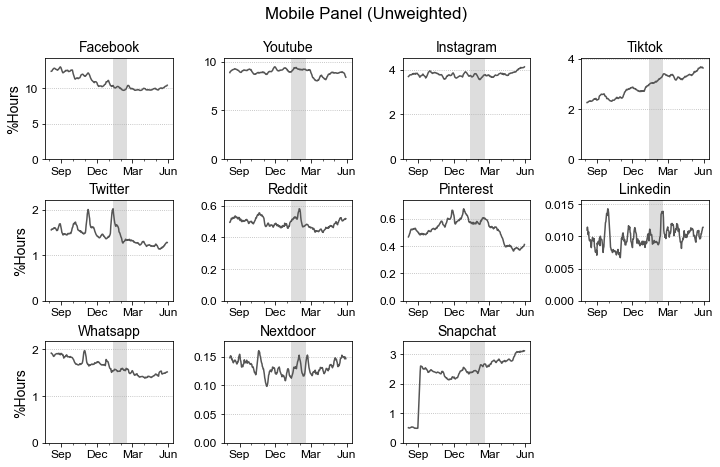

In [13]:
import matplotlib


mainstream_platforms = ["facebook", "youtube", "instagram", "tiktok", 
 "twitter", "reddit", "pinterest",
 "linkedin", "whatsapp", "nextdoor", "snapchat"]

params = [
    (w, w_all, "desk", "./images/overall_mainstream_desktop_dau.pdf", "usersw"),
    (w_mob, w_all_mob, "mobile", "./images/overall_mainstream_mobile_dau.pdf", "usersw"),
    (w, w_all, "desk", "./images/overall_mainstream_desktop_dau_uw.pdf", "users"),
    (w_mob, w_all_mob, "mobile", "./images/overall_mainstream_mobile_dau_uw.pdf", "users"),
    (w, w_all, "desk", "./images/overall_mainstream_desktop_hours.pdf", "sumv"),
    (w_mob, w_all_mob, "mobile", "./images/overall_mainstream_mobile_hours.pdf", "sumv"),
    (w, w_all, "desk", "./images/overall_mainstream_desktop_hours_uw.pdf", "dur"),
    (w_mob, w_all_mob, "mobile", "./images/overall_mainstream_mobile_hours_uw.pdf", "dur"),
]

myFmt = mdates.DateFormatter('%b')
for w_, w_all_, k, fig_path, valk in params:
    fig = plt.figure(constrained_layout=False, figsize=(10, 6.5))
    axs = fig.subplot_mosaic([["facebook", "youtube", "instagram", "tiktok", ],
                               ["twitter", "reddit", "pinterest", "linkedin"],
                              ["whatsapp", "nextdoor", "snapchat", "delete"]],
                            gridspec_kw={'wspace': 0.4, "hspace": 0.4})

    t_all = w_all_.groupby([pd.Grouper(key="activitydatetime", freq="D")])\
                 .apply(weighted_agg)
    for platform in mainstream_platforms:
        print(platform)
        w_[platform] = w_["platform"] == platform
        t = w_.groupby([pd.Grouper(key="activitydatetime", freq="D"),  platform]).apply(weighted_agg).reset_index()
        t2 = t.set_index("activitydatetime")
        ytmp = t2[t2[platform]][valk].rolling(7, center=False).mean() /\
                    t_all[valk].rolling(7, center=False).mean() * 100

        axs[platform].plot(ytmp, color="#555", ls = "-")
        axs[platform].xaxis.set_major_formatter(myFmt)
        axs[platform].axvspan(pd.to_datetime("2021-01-11"), pd.to_datetime("2021-02-15"), 
                              color="#DDDDDD", zorder=-2, label="Parler shutdown")
        axs[platform].yaxis.grid("#C0C0C0", ls=":")
        axs[platform].set_title(platform.upper()[0] + platform[1:])

        axs[platform].xaxis.set_major_locator(dates.MonthLocator(interval=3))
        axs[platform].xaxis.set_minor_locator(dates.MonthLocator(interval=1))
        axs[platform].set_ylim(bottom=0, top=max(ytmp.dropna()) * 1.1)

    axs["facebook"].set_ylabel("%DAU" if valk in ["users", "usersw"] else "%Hours")
    axs["twitter"].set_ylabel("%DAU" if valk in ["users", "usersw"] else "%Hours")
    axs["whatsapp"].set_ylabel("%DAU" if valk in ["users", "usersw"] else "%Hours")
    fig.delaxes(axs["delete"])
    accv = " (Unweighted)" if valk in ["users", "dur"] else ""
    fig.suptitle("Desktop Panel" + accv if k == "desk" else "Mobile Panel" + accv)
    set_size(fig, (10,  6.5))
    fig.savefig(fig_path, bbox_inches="tight")
    plt.show()


telegram
locals
gab
rumble
bitchute
8kun
mewe
dlive
minds
4chan


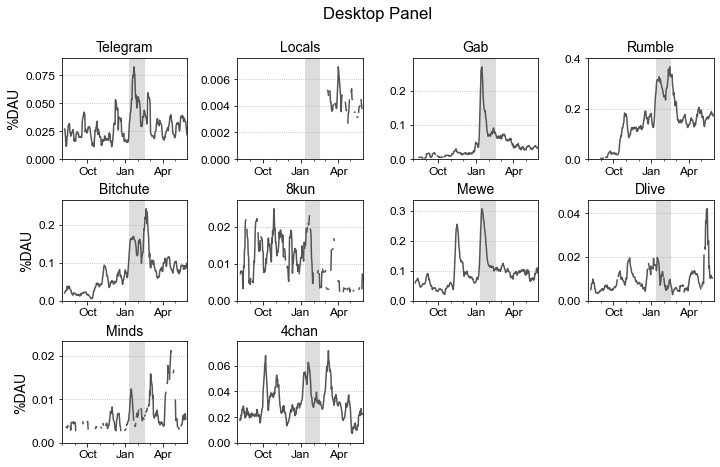

telegram
locals
gab
rumble
bitchute
8kun
mewe
dlive
minds
4chan


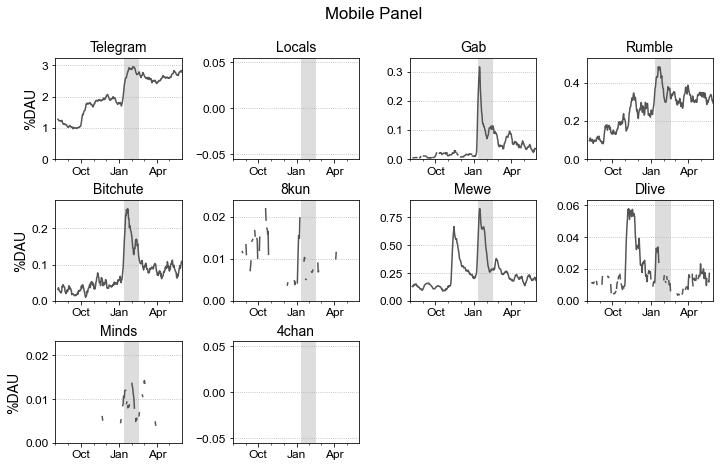

telegram
locals
gab
rumble
bitchute
8kun
mewe
dlive
minds
4chan


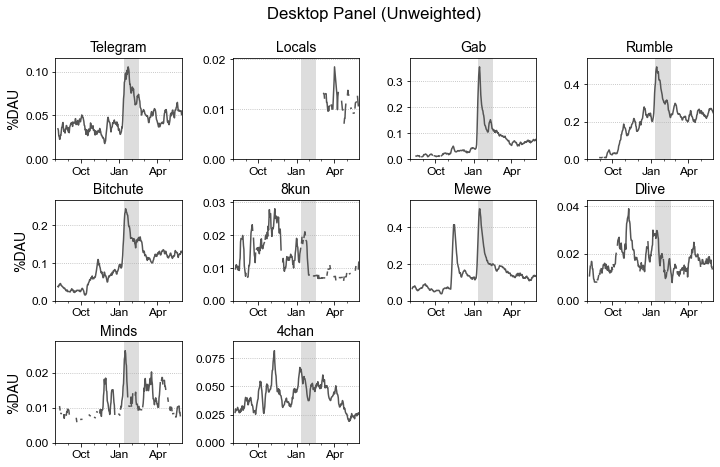

telegram
locals
gab
rumble
bitchute
8kun
mewe
dlive
minds
4chan


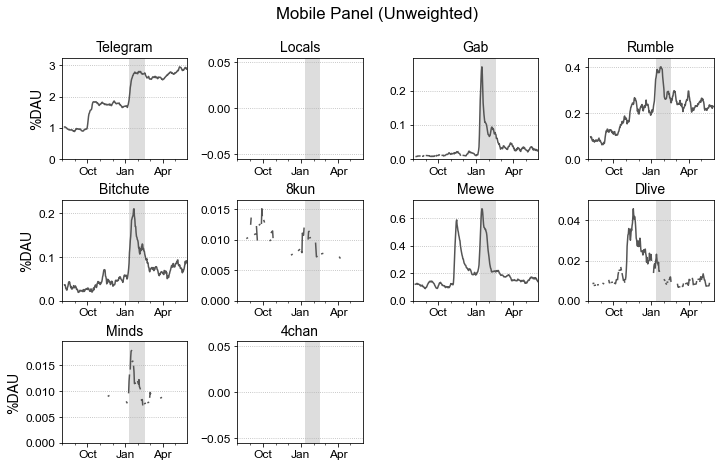

telegram
locals
gab
rumble
bitchute
8kun
mewe
dlive
minds
4chan


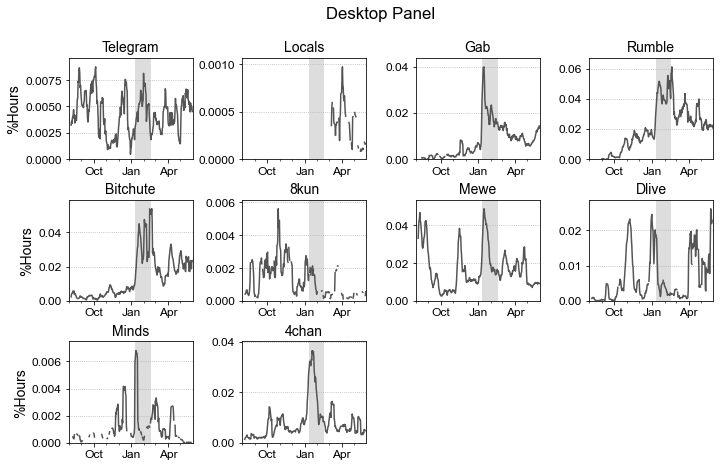

telegram
locals
gab
rumble
bitchute
8kun
mewe
dlive
minds
4chan


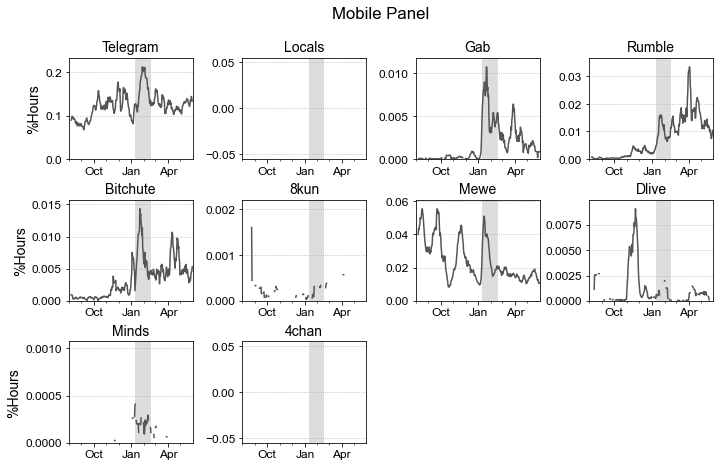

telegram
locals
gab
rumble
bitchute
8kun
mewe
dlive
minds
4chan


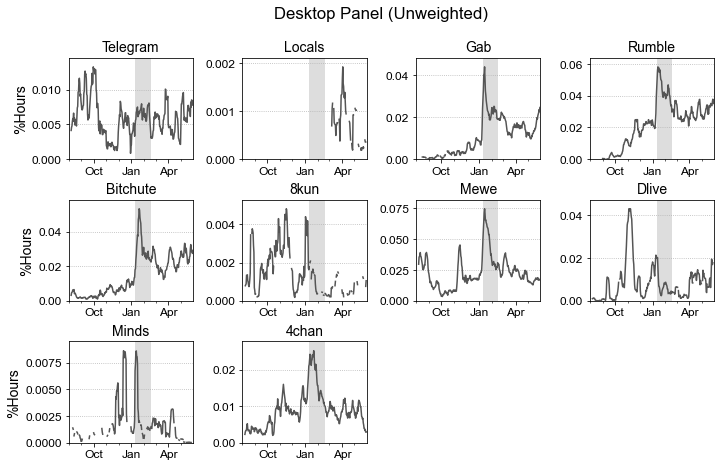

telegram
locals
gab
rumble
bitchute
8kun
mewe
dlive
minds
4chan


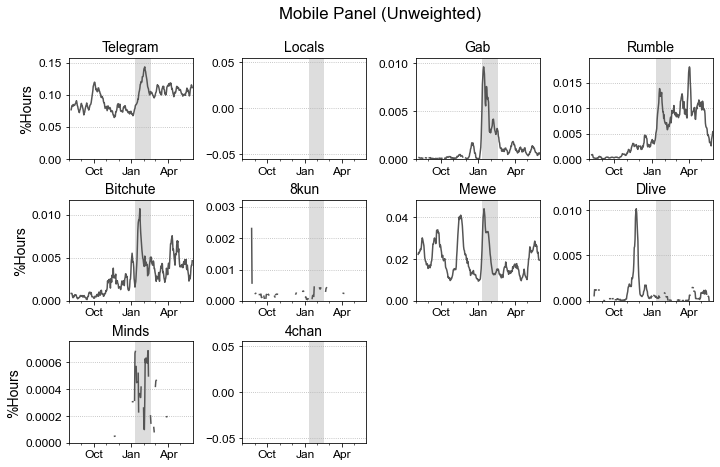

In [14]:
import matplotlib


fringe_platforms = ["telegram", "locals", "gab", "rumble", "bitchute", 
                    "8kun", "mewe", "dlive", "minds", "4chan"]

params = [
    (w, w_all, "desk", "./images/overall_fringe_desktop_dau.pdf", "usersw"),
    (w_mob, w_all_mob,  "mobile", "./images/overall_fringe_mobile_dau.pdf", "usersw"),
    (w, w_all, "desk", "./images/overall_fringe_desktop_dau_uw.pdf", "users"),
    (w_mob, w_all_mob,  "mobile", "./images/overall_fringe_mobile_dau_uw.pdf", "users"),
    (w, w_all, "desk", "./images/overall_fringe_desktop_hours.pdf", "sumv"),
    (w_mob, w_all_mob,  "mobile", "./images/overall_fringe_mobile_hours.pdf", "sumv"),
    (w, w_all, "desk", "./images/overall_fringe_desktop_hours_uw.pdf", "dur"),
    (w_mob, w_all_mob,  "mobile", "./images/overall_fringe_mobile_hours_uw.pdf", "dur"),
]

myFmt = mdates.DateFormatter('%b')
for w_, w_all_, k, fig_path, valk in params:
    fig = plt.figure(constrained_layout=False, figsize=(10, 6.5))
    axs = fig.subplot_mosaic([["telegram", "locals", "gab", "rumble"],
                              ["bitchute", "8kun", "mewe", "dlive"],
                              ["minds", "4chan", "delete1", "delete2"]],
                            gridspec_kw={'wspace': 0.4, "hspace": 0.4})

    t_all = w_all_.groupby([pd.Grouper(key="activitydatetime", freq="D")])\
                 .apply(weighted_agg)
    for platform in fringe_platforms:
        print(platform)
        w_[platform] = w_["platform"] == platform
        t = w_.groupby([pd.Grouper(key="activitydatetime", freq="D"),  platform]).apply(weighted_agg).reset_index()
        t2 = t.set_index("activitydatetime")
        ytmp = t2[t2[platform]][valk].rolling(7, center=False).mean() /\
                    t_all[valk].rolling(7, center=False).mean() * 100

        axs[platform].plot(ytmp, color="#555", ls = "-")
        axs[platform].xaxis.set_major_formatter(myFmt)
        axs[platform].xaxis.set_major_formatter(myFmt)
        axs[platform].axvspan(pd.to_datetime("2021-01-11"), pd.to_datetime("2021-02-15"), 
                              color="#DDDDDD", zorder=-2, label="Parler shutdown")
        axs[platform].yaxis.grid("#C0C0C0", ls=":")
        axs[platform].set_title(platform.upper()[0] + platform[1:])

        axs[platform].xaxis.set_major_locator(dates.MonthLocator(interval=3))
        axs[platform].xaxis.set_minor_locator(dates.MonthLocator(interval=1))
        try:
            axs[platform].set_ylim(bottom=0, top=max(ytmp.dropna()) * 1.1)
        except:
            pass
        axs[platform].set_xlim([pd.to_datetime("2020-08-01"), pd.to_datetime("2021-05-31")])
    

    axs["telegram"].set_ylabel("%DAU" if valk in ["users", "usersw"] else "%Hours")
    axs["bitchute"].set_ylabel("%DAU" if valk in ["users", "usersw"] else "%Hours")
    axs["minds"].set_ylabel("%DAU" if valk in ["users", "usersw"] else "%Hours")
    fig.delaxes(axs["delete1"])
    fig.delaxes(axs["delete2"])
    accv = " (Unweighted)" if valk in ["users", "dur"] else ""
    fig.suptitle("Desktop Panel" + accv if k == "desk" else "Mobile Panel" + accv)
    set_size(fig, (10,  6.5))
    fig.savefig(fig_path, bbox_inches="tight")
    
    ax_list = [axs[platform] for platform in fringe_platforms] 

    plt.show()


# Additional plots

In [16]:
def plot_helper1(w_desktop,
                 w_all_desktop,
                 w_mob,
                 w_all_mob,
                 denom_main, 
                 slindw_main,
                 ylabel_main,
                 pathfig,
                 annotate_coords = None,
                 fmt = '%.1f', 
                 kval="sumv",
                 sept_dau=True):

    myFmt = mdates.DateFormatter('%b')
    xticks = mtick.FormatStrFormatter(fmt)

    fig = plt.figure(constrained_layout=False, figsize=(10, 9))
    
    axs = fig.subplot_mosaic(np.array([['desk', 'desk', 'mob', 'mob']]).T, 
                              gridspec_kw={ 'hspace': 0.8})
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    import matplotlib.transforms as transforms


    # MAIN PLOT 
    for w, w_all, k in [(w_desktop, w_all_desktop, "desk"), (w_mob, w_all_mob, "mob")]:
        
        w["parler"] = w["platform"] == "parler"
        w["is_fringe"] = w["platform"].isin(
            ["locals", "parler", "minds", "8kun", "dlive", "gab", 
             "4chan", "rumble", "bitchute", "mewe", "telegram"])
        t = w[w.is_fringe].groupby([pd.Grouper(key="activitydatetime", freq="D"), "parler"])\
                          .apply(weighted_agg).reset_index()
        t_all = w_all.groupby([pd.Grouper(key="activitydatetime", freq="D")])\
                     .apply(weighted_agg)
        t2 = t.set_index("activitydatetime")
        t3 = t2[t2.parler][kval].rolling(slindw_main, center=False).mean() / denom_main(t_all)
        axs[k].plot(t3, 
                         label="Parler" if k == "desk" else None, 
                         color=parlercolor, ls="-" if k == "desk" else "-")
        t4 = t2[~t2.parler][kval].rolling(slindw_main, center=False).mean() / denom_main(t_all)
        axs[k].plot(t4.rolling(1).mean(), 
                         label="Other fringe\nsocial media" if k == "desk" else None, 
                         color=othercolor, ls="-" if k == "desk" else "-")
        

        # plots september average
        if sept_dau:
            tb = w[w.is_fringe].groupby([pd.Grouper(key="activitydatetime", freq="D")])\
                          .apply(weighted_agg).reset_index()
            tb_all = w_all.groupby([pd.Grouper(key="activitydatetime", freq="D")])\
                         .apply(weighted_agg)
            tmp = tb.set_index("activitydatetime")
            tmp = tmp[kval] / denom_main(tb_all) 
            tmp = tmp.reset_index()
            tmp = tmp[(tmp["activitydatetime"] >= pd.to_datetime("2020-09-01")) &
                   (tmp["activitydatetime"] < pd.to_datetime("2020-10-01"))][kval]
            axs[k].fill_between([pd.to_datetime("2021-04-15"), pd.to_datetime("2021-05-31")],
                                [tmp.min(), tmp.min()], 
                                [tmp.max(), tmp.max()], 
                                color="#333", alpha=0.10)

            axs[k].plot([pd.to_datetime("2021-04-15"), pd.to_datetime("2021-05-31")], 
                        [tmp.mean(), tmp.mean()], 
                        color="#333", ls="--")
            axs[k].text(pd.to_datetime("2021-04-14"),tmp.mean(), "September %DAU of\nfringe social networks",
                        ha="right", va="center", size=10)

        # gets max values oct / nov / jan
        tmp = t3.reset_index()
        tmp = tmp[(tmp["activitydatetime"] >= pd.to_datetime("2020-10-01")) &
               (tmp["activitydatetime"] < pd.to_datetime("2020-11-01"))]
        print("October max:", tmp[kval].max())
        tmp = t3.reset_index()
        tmp= tmp[(tmp["activitydatetime"] >= pd.to_datetime("2020-11-01")) &
               (tmp["activitydatetime"] < pd.to_datetime("2020-12-01"))]
        print("November max:", tmp[kval].max())
                   
        tmp = t3.reset_index()
        tmp= tmp[(tmp["activitydatetime"] >= pd.to_datetime("2021-01-01")) &
               (tmp["activitydatetime"] < pd.to_datetime("2021-01-30"))]
        print("January max (parler):", tmp[kval].max())
        tmp = t4.reset_index()
        tmp= tmp[(tmp["activitydatetime"] >= pd.to_datetime("2021-01-01")) &
               (tmp["activitydatetime"] < pd.to_datetime("2021-01-30"))]
        print("January max (other):", tmp[kval].max())
        

    # AESTHETICS MAIN PLOT
    for k in ["desk", "mob"]:
        axs[k].set_ylabel(ylabel_main, size=14)
        axs[k].yaxis.grid("#C0C0C0", ls=":")
        sns.despine(ax=axs[k])

        axs[k].axvline(pd.to_datetime("2020-11-03"), color="black", ls="--", zorder=-1, lw=1.25)
        axs[k].axvline(pd.to_datetime("2021-01-06"), color="black", ls="--", zorder=-1, lw=1.25)
        axs[k].xaxis.set_major_locator(dates.MonthLocator(interval=1))
        axs[k].axvspan(pd.to_datetime("2021-01-10"), pd.to_datetime("2021-02-15"), color="#DDDDDD", zorder=-2)
        axs[k].xaxis.set_major_formatter(myFmt)
        if k == "mob":
            plot_top(axs[k], pd.to_datetime("2020-09-17"), text="2020", size=14, delta=-1.17)
            plot_top(axs[k], pd.to_datetime("2021-03-17"), text="2021", size=14, delta=-1.17)

        axs[k].yaxis.set_major_formatter(xticks)
        
        plot_top(axs[k], pd.to_datetime("2020-11-03"), text="Election", size=12, delta=-0.01)
        plot_top(axs[k], pd.to_datetime("2021-01-06"), text="Capitol attack", size=12, delta=-0.01)
        if k == "desk":
            # ANNOTATE MAIN PLOT    
            if annotate_coords is not None:
                axs[k].annotate("Parler shutdown", xy=(pd.to_datetime("2021-02-17"), annotate_coords[0]), 
                                 xytext=(pd.to_datetime("2021-04-15"), annotate_coords[1]),
                                 xycoords="data", annotation_clip=False, ha="center", color="#777777",
                                 arrowprops={"connectionstyle": "arc3,rad=.5", "arrowstyle": "-|>", 
                                               "color": "#777777"}, size=14)
        axs[k].legend(frameon=False, fontsize=14, loc="upper left")
#     accv = " (Unweighted)"  if kval not in ["usersw", "sumv"] else ""
    accv = ""
    axs["desk"].set_title("Desktop Panel" + accv, pad=30, fontsize=16)
    axs["mob"].set_title("Mobile Panel" + accv, pad=30, fontsize=16)

    ax_list = [axs[k] for k in ["desk", "mob"]] 

    axs["desk"].get_shared_y_axes().join(ax_list[0], *ax_list)

    set_size(fig, (10,  9))
    fig.savefig(pathfig, bbox_inches="tight",dpi=300)
    fig.savefig(pathfig.replace("pdf", "png"), bbox_inches="tight",dpi=300)

October max: 0.12178842525074886
November max: 0.8365372939956869
January max (parler): 0.9624655335113805
January max (other): 1.0975540219889268


/tmp/ipykernel_13999/3535296186.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w["parler"] = w["platform"] == "parler"
/tmp/ipykernel_13999/3535296186.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w["is_fringe"] = w["platform"].isin(
No handles with labels found to put in legend.


October max: 0.25055104778971876
November max: 1.545109543353785
January max (parler): 3.5186463682855607
January max (other): 4.238168779780957


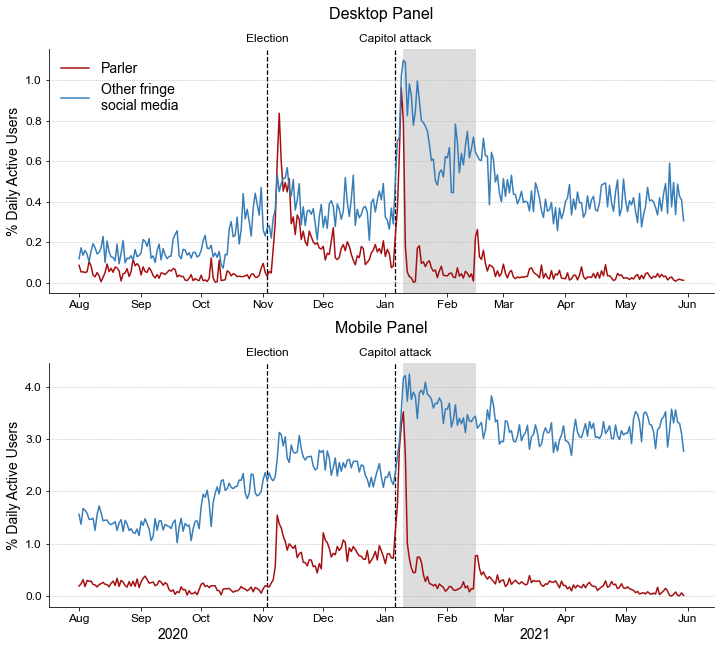

In [17]:
plot_helper1(
w_desktop = w,
w_mob = w_mob[w_mob.personweight > 0],
w_all_desktop = w_all,
w_all_mob = w_all_mob[w_all_mob.personweight > 0],
denom_main = lambda sumv: sumv.usersw/100, 
slindw_main = 1,
ylabel_main = '% Daily Active Users',
annotate_coords = None,#(0.8, 0.7),
pathfig = "./images/overall_desktop_dau.pdf",
fmt = '%.1f',
kval = "usersw",
sept_dau=False)

October max: 0.011842357385306033
November max: 0.11201896511015406
January max (parler): 0.18837409400889132
January max (other): 0.3872063351750971


/tmp/ipykernel_6661/3535296186.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w["parler"] = w["platform"] == "parler"
/tmp/ipykernel_6661/3535296186.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w["is_fringe"] = w["platform"].isin(
No handles with labels found to put in legend.


October max: 0.01861830325265264
November max: 0.08351720892157165
January max (parler): 0.354938821839491
January max (other): 0.2248720403405836


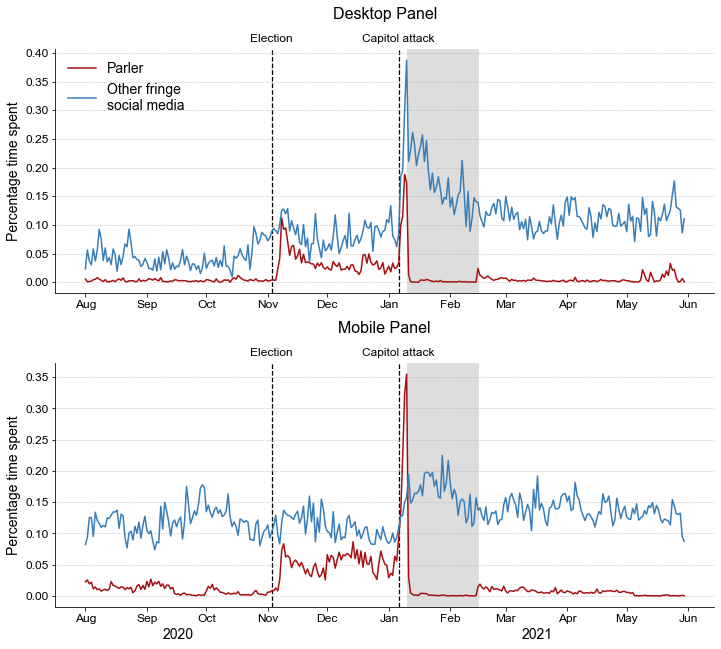

In [15]:
plot_helper1(
w_desktop = w,
w_mob = w_mob[(w_mob.personweight > 0)],
w_all_desktop = w_all,
w_all_mob = w_all_mob[(w_all_mob.personweight > 0)],
denom_main = lambda sumv: sumv.dur.rolling(1, center=False).mean() / 100, 
slindw_main = 1,
ylabel_main = 'Percentage time spent',
annotate_coords = None,
pathfig = "./images/overall_desktop_hours.pdf",
fmt = '%.2f',
kval = "dur",
sept_dau=False)